In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, ReLU, MaxPool2D, Add, Dense, Dropout, Flatten, GlobalAveragePooling2D
import tensorflow.compat.v1 as tf1
from tensorflow.keras.mixed_precision import experimental as mixed_precision


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import numpy as np

import PIL
from PIL import Image, ImageDraw, ImageEnhance

import albumentations as albu

from tqdm.auto import tqdm

import random
random.seed(42)

from warnings import filterwarnings

%matplotlib inline

In [2]:
filterwarnings('ignore')

In [3]:
config = tf1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf1.Session(config=config)
tf1.keras.backend.set_session(session=sess)

In [4]:
# gpu_options = tf1.GPUOptions(per_process_gpu_memory_fraction=0.9999)
# sess = tf1.Session(config=tf1.ConfigProto(gpu_options=gpu_options))
# tf1.keras.backend.set_session(session=sess)

In [5]:
policy = mixed_precision.Policy('float32')
mixed_precision.set_policy(policy)

In [6]:
# OpenCV with GPU variable
use_GPU = False

In [7]:
df_train = pd.read_csv("./dataset/train.csv")
df_train.head(5)

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [8]:
df_train.isnull().sum()

image_id    0
width       0
height      0
bbox        0
source      0
dtype: int64

In [9]:
image_id_values = df_train["image_id"].unique()

In [10]:
len(image_id_values)

3373

In [11]:
train_image_ids = image_id_values[0:3363]
val_image_ids = image_id_values[3363:3373]

In [12]:
def group_boxes(group):
    boundaries = group['bbox'].str.split(',', expand=True)
    boundaries[0] = boundaries[0].str.slice(start=1)
    boundaries[3] = boundaries[3].str.slice(stop=-1)
    
    return boundaries.values.astype(float)

bboxes = df_train.groupby('image_id').apply(group_boxes)

In [13]:
bboxes['bce2fdc4d'][:5]

array([[ 59.,   0., 133.,  42.],
       [742., 839., 115.,  92.],
       [302., 665., 117.,  95.],
       [120., 816., 133.,  82.],
       [424., 486., 111.,  74.]])

In [14]:
def load_image(image_id):
    
    global use_GPU
    if use_GPU:
        image = cv2.UMat(cv2.imread('./dataset/train/'+image_id+'.jpg'))
    else:
        image = cv2.imread('./dataset/train/'+image_id+'.jpg')
        
    if use_GPU:
        if len(cv2.UMat.get(image)) == 0:
            raise ValueError(f"Image could not be located")
    else:
        if len(image) == 0:
            raise ValueError(f"Image could not be located")
    image = cv2.resize(image, (256, 256))
    
    if use_GPU:
        return cv2.UMat.get(image)
    else:
        return image

In [15]:
train_pixels = {}
train_labels = {}

for image_id in tqdm(train_image_ids):
    
    train_pixels[image_id] = load_image(image_id)
    train_labels[image_id] = bboxes[image_id].copy() / 4

In [16]:
val_pixels = {}
val_labels = {}

for image_id in tqdm(val_image_ids):
    val_pixels[image_id] = load_image(image_id)
    val_labels[image_id] = bboxes[image_id].copy() / 4

In [17]:
type(train_pixels['b6ab77fd7'])

numpy.ndarray

In [18]:
len(train_labels['b6ab77fd7'])

47

In [19]:
def draw_bboxes(image_id, bboxes, source='train'):
    if use_GPU:
        image = cv2.UMat(cv2.imread('./dataset/'+source+'/'+image_id+'.jpg'))
    else:
        image = cv2.imread('./dataset/'+source+'/'+image_id+'.jpg')
    image = cv2.resize(image, (256, 256))
    
#     cv2.imshow('image', image)
#     cv2.waitKey()
#     cv2.destroyAllWindows()
    
    for bbox in bboxes:
        image = draw_bbox(image, bbox)
        
    return image
def draw_bbox(image, bbox):
    x, y, w, h = bbox
    image = cv2.rectangle(image,
                          (int(x), int(y)),
                          (int(x+w), int(y+h)),
                          (225,0,0), 
                          1)
    return image

In [20]:
def show_images(image_ids, bboxes, source='train'):
    pixels = []
    global use_GPU
    
    for image_id in image_ids:
        pixels.append(
            draw_bboxes(image_id, bboxes[image_id], source)
        )
        
    num_of_images = len(image_ids)
    fig, axes = plt.subplots(1, num_of_images, figsize=(10*num_of_images, 10*num_of_images))
    
    for i, image_pixels in enumerate(pixels):
        if use_GPU:
            axes[i].imshow(cv2.UMat.get(image_pixels))
        else:
            axes[i].imshow(image_pixels)
    #plt.show()

# Images with Bounding Boxes

CPU times: user 43.9 ms, sys: 3.43 ms, total: 47.4 ms
Wall time: 44.6 ms


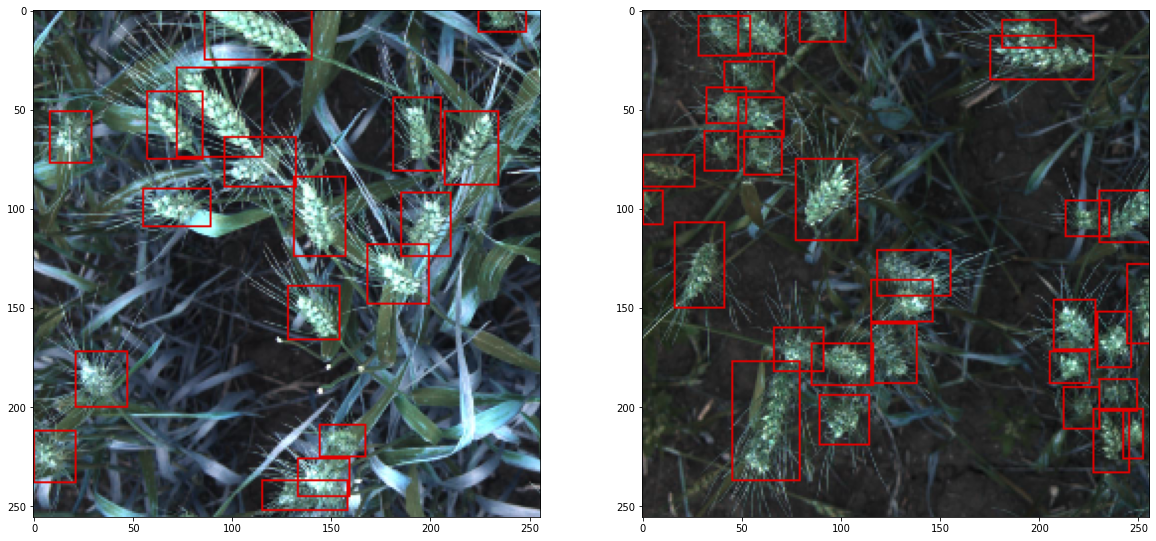

In [21]:
%%time
show_images((train_image_ids[100:102]),(train_labels))

In [22]:
def draw_grid_lines(image_id, labels, grid_line_distance=32, source='train'):
    global use_GPU
    
    image_path = './dataset/'+source+'/'+image_id+'.jpg'
    if use_GPU:
        image = cv2.UMat(draw_bboxes(image_id, labels))
    else:
        image = draw_bboxes(image_id, labels)
    image = cv2.resize(image, (256, 256))
    
    # Vertical Lines
    prev_x = 0
    prev_y = 0
    for dist in range(0, 256, grid_line_distance):
        image = cv2.line(image, (prev_x, prev_y+(dist-prev_y)), (prev_x+256, prev_y+(dist-prev_y)), (0, 0, 255), 1, 1)
        prev_x = prev_x
        prev_y = dist
    
    # Horizontal Lines
    prev_x = 0
    prev_y = 0
    for dist in range(0, 256, grid_line_distance):
        image = cv2.line(image, (prev_x+(dist-prev_x), prev_y), (prev_x+(dist-prev_x), prev_y+256), (0, 0, 255), 1, 1)
        prev_x = dist
        prev_y = prev_y
        
    if use_GPU:
        image = cv2.UMat.get(image)
        
    else:
        image = image

    return image
        

## Which grid size is optimal to select for Yolo-Similar model with an input image size of `256*256`?

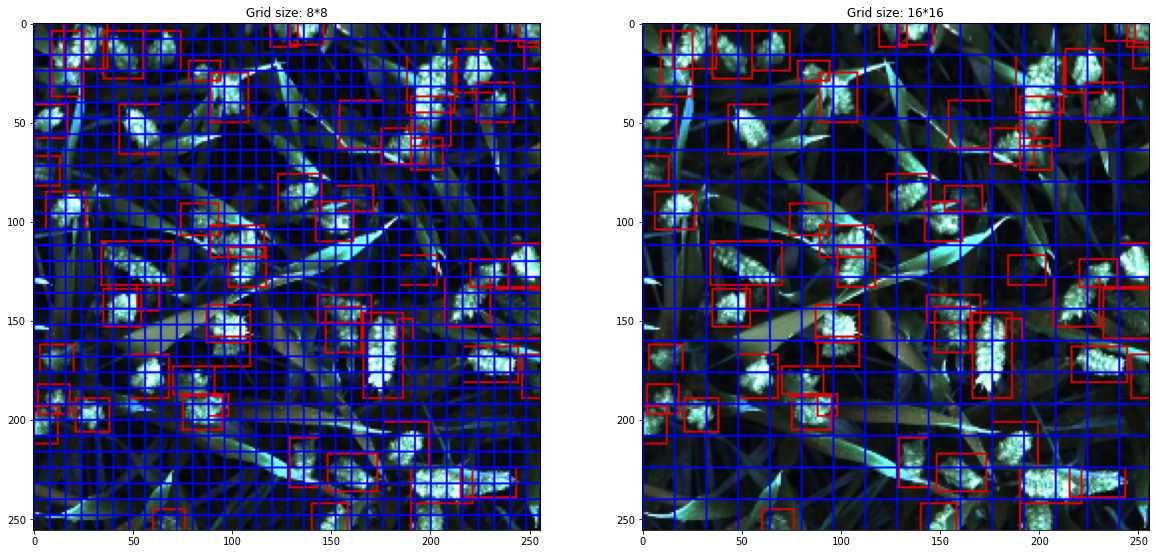

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(10*2, 10*2))
image_id = train_image_ids[3000]
ax[0].set_title('Grid size: 8*8')
ax[0].imshow(draw_grid_lines(image_id, train_labels[image_id], grid_line_distance=8 )) # 8*8 grid
ax[1].set_title('Grid size: 16*16')
ax[1].imshow(draw_grid_lines(image_id, train_labels[image_id], grid_line_distance=16 )) # 16*16 grid
fig.show()

In [24]:
train_image_ids[100]

'4d60c73db'

### Cleaning Very small boxes

In [25]:
tiny_boxes = []

for i, image_id in enumerate(train_image_ids):
    for label in train_labels[image_id]:
        if label[2]*label[3] <= 10 and label[2]*label[3] != 0:
            tiny_boxes.append(i)
print(str(len(tiny_boxes)) + ' tiny boxes found')

49 tiny boxes found


In [26]:
def clean_labels(train_image_ids, train_labels):
    good_labels = {}
    
    for i, image_id in enumerate(train_image_ids):
        good_labels[image_id] = []
        
        for j, label in enumerate(train_labels[image_id]):
            
            if label[2]*label[3] > 8000 and i not in [1079, 1371, 2020]:
                continue
                
            elif label[2]<5 or label[3]<5:
                continue
                
            else:
                good_labels[image_id].append(
                    train_labels[image_id][j]
                )
    return good_labels

In [27]:
train_labels = clean_labels(train_image_ids, train_labels)

# DataGenerator

In [28]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, image_ids, image_pixels, labels=None, batch_size=1, shuffle=False, augment=False):
        self.image_ids = image_ids
        self.image_pixels = image_pixels
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        self.image_grid = self.form_image_grid()
        
        
    def form_image_grid(self):    
        image_grid = np.zeros((32, 32, 4))

        # x, y, width, height
        cell = [0, 0, 256 / 32, 256 / 32] 

        for i in range(0, 32):
            for j in range(0, 32):
                image_grid[i,j] = cell

                cell[0] = cell[0] + cell[2]

            cell[0] = 0
            cell[1] = cell[1] + cell[3]

        return image_grid

In [29]:
def __len__(self):
    return int(np.floor(len(self.image_ids) / self.batch_size))


def on_epoch_end(self):
    self.indexes = np.arange(len(self.image_ids))

    if self.shuffle == True:
        np.random.shuffle(self.indexes)


DataGenerator.__len__ = __len__
DataGenerator.on_epoch_end = on_epoch_end

In [30]:
DataGenerator.train_augmentations = albu.Compose([
        albu.RandomSizedCrop(
            min_max_height=(200, 200), 
            height=256, 
            width=256, 
            p=0.8
        ),
        albu.OneOf([
            albu.Flip(),
            albu.RandomRotate90(),
        ], p=1),
        albu.OneOf([
            albu.HueSaturationValue(),
            albu.RandomBrightnessContrast()
        ], p=1),
        albu.OneOf([
            albu.GaussNoise(),
            albu.GlassBlur(),
            albu.ISONoise(),
            albu.MultiplicativeNoise(),
        ], p=0.5),
        albu.Cutout(
            num_holes=8, 
            max_h_size=16, 
            max_w_size=16, 
            fill_value=0, 
            p=0.5
        ),
        albu.CLAHE(p=1),
        albu.ToGray(p=1),
    ], 
    bbox_params={'format': 'coco', 'label_fields': ['labels']})

DataGenerator.val_augmentations = albu.Compose([
    albu.CLAHE(p=1),
    albu.ToGray(p=1),
])

In [31]:
def __getitem__(self, index):
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    batch_ids = [self.image_ids[i] for i in indexes]

    X, y = self.__data_generation(batch_ids)

    return X, y


def __data_generation(self, batch_ids):
    X, y = [], []

    # Generate data
    for i, image_id in enumerate(batch_ids):
        pixels = self.image_pixels[image_id]
        bboxes = self.labels[image_id]

        if self.augment:     
            pixels, bboxes = self.augment_image(pixels, bboxes)
        else:
            pixels = self.contrast_image(pixels)
            bboxes = self.form_label_grid(bboxes)

        X.append(pixels)
        y.append(bboxes)

    return np.array(X), np.array(y)


def augment_image(self, pixels, bboxes):
    bbox_labels = np.ones(len(bboxes))

    aug_result = self.train_augmentations(image=pixels, bboxes=bboxes, labels=bbox_labels)

    bboxes = self.form_label_grid(aug_result['bboxes'])

    return np.array(aug_result['image']) / 255, bboxes


def contrast_image(self, pixels):        
    aug_result = self.val_augmentations(image=pixels)
    return np.array(aug_result['image']) / 255


DataGenerator.__getitem__ = __getitem__
DataGenerator.__data_generation = __data_generation
DataGenerator.augment_image = augment_image
DataGenerator.contrast_image = contrast_image

In [32]:
def form_label_grid(self, bboxes):
    label_grid = np.zeros((32, 32, 10))

    for i in range(0, 32):
        for j in range(0, 32):
            cell = self.image_grid[i,j]
            label_grid[i,j] = self.rect_intersect(cell, bboxes)

    return label_grid


def rect_intersect(self, cell, bboxes): 
    cell_x, cell_y, cell_width, cell_height = cell
    cell_x_max = cell_x + cell_width 
    cell_y_max = cell_y + cell_height
    
    anchor_one = np.array([0, 0, 0, 0, 0])
    anchor_two = np.array([0, 0, 0, 0, 0])

    # check all boxes
    for bbox in bboxes:
        box_x, box_y, box_width, box_height = bbox
        box_x_centre = box_x + (box_width / 2)
        box_y_centre = box_y + (box_height / 2)

        if(box_x_centre >= cell_x and box_x_centre < cell_x_max and box_y_centre >= cell_y and box_y_centre < cell_y_max):
            
            if anchor_one[0] == 0:
                anchor_one = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
            
            elif anchor_two[0] == 0:
                anchor_two = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
                
            else:
                break

    return np.concatenate((anchor_one, anchor_two), axis=None)


def yolo_shape(self, box, cell):
    box_x, box_y, box_width, box_height = box
    cell_x, cell_y, cell_width, cell_height = cell

    # top left x,y to centre x,y
    box_x = box_x + (box_width / 2)
    box_y = box_y + (box_height / 2)

    # offset bbox x,y to cell x,y
    box_x = (box_x - cell_x) / cell_width
    box_y = (box_y - cell_y) / cell_height

    # bbox width,height relative to cell width,height
    box_width = box_width / 256
    box_height = box_height / 256

    return [1, box_x, box_y, box_width, box_height]


DataGenerator.form_label_grid = form_label_grid
DataGenerator.rect_intersect = rect_intersect
DataGenerator.yolo_shape = yolo_shape

In [33]:
BATCH_SIZE = 2

train_generator = DataGenerator(
    train_image_ids,
    train_pixels,
    train_labels, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    augment=True
)

val_generator = DataGenerator(
    val_image_ids, 
    val_pixels,
    val_labels, 
    batch_size=10,
    shuffle=False,
    augment=False
)

image_grid = train_generator.image_grid

In [34]:
### Using Kaggle TPU for taining.

In [35]:
### For Using Kaggle TPU for training.
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [36]:
def add_main_block(num_times_to_add_block: int, x, x_shortcut, filters: int, kernel_size: tuple, strides: tuple, block_number=None, padding: str ='same', alpha: str = 0.1):
    
    for _ in range(num_times_to_add_block):
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=alpha)(x)
    
        x = Conv2D(filters*2, kernel_size, strides=strides, padding=padding)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=alpha)(x)
    
        x = Add()([x_shortcut, x])
        x = LeakyReLU(alpha=alpha)(x)
        
        x_shortcut = x
        
    return x, x_shortcut



def add_res_block(x, x_shortcut=None, filters: int = None, kernel_size: tuple = None, strides: tuple = None, block_number=None, padding: str = 'same', alpha: float = 0.1):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=alpha)(x)

    x_shortcut = x
    
    return x, x_shortcut

In [37]:
def custom_loss(y_true, y_pred):
    
    global BATCH_SIZE
    
    #------------- For GPU Computing ----------------#
    binary_crossentropy = prob_loss = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )

    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0), 
        tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
     )
    #-------------- End of GPU Computing ---------------#
    
    
    
    #------------ For TPU Computing ------------#
#     binary_crossentropy = prob_loss = tf.keras.losses.BinaryCrossentropy(
#         reduction=tf.keras.losses.Reduction.NONE)
    
#     # Binary Cross Entropy loss for TPU Computing.
#     reduce_sum = tf.reduce_sum(binary_crossentropy(
#         tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0),
#         tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
#     ))
    
#     prob_loss = reduce_sum * (1. / BATCH_SIZE)
    #-------------- End of TPU Computing --------------#
    
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,1:3], y_true[:,:,:,6:8]], axis=0), 
        tf.concat([y_pred[:,:,:,1:3], y_pred[:,:,:,6:8]], axis=0)
    )
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,3:5], y_true[:,:,:,8:10]], axis=0), 
        tf.concat([y_pred[:,:,:,3:5], y_pred[:,:,:,8:10]], axis=0)
    )
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss * bboxes_mask
    wh_loss = wh_loss * bboxes_mask
    
    return prob_loss + xy_loss + wh_loss


def get_mask(y_true):
    anchor_one_mask = tf.where(
        y_true[:,:,:,0] == 0, 
        0.5, 
        5.0
    )
    
    anchor_two_mask = tf.where(
        y_true[:,:,:,5] == 0, 
        0.5, 
        5.0
    )
    
    bboxes_mask = tf.concat(
        [anchor_one_mask,anchor_two_mask],
        axis=0
    )
    
    return bboxes_mask

In [38]:
#with tpu_strategy.scope():


x_input = Input(shape=(256, 256, 3))

x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x_input)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)


#------------ Block 1 -------------#
#-- Res-block-1 --#
x, x_shortcut = add_res_block(x, filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)
#-- Main-Block-1 --#
x, x_shortcut = add_main_block(2, x, x_shortcut, 32, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)


#------------ Block 2 -------------#
#-- Res-block-2 --#
x, x_shortcut = add_res_block(x, x_shortcut=x_shortcut, filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)
#-- Main-Block 2 --#
x, x_shortcut = add_main_block(2, x, x_shortcut, 64, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)


#------------ Block 3 -------------#
#-- Res-block 3 --#
x, x_shortcut = add_res_block(x, x_shortcut, filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same', alpha=0.1)
#-- Main-Block --#
x, x_shortcut = add_main_block(2, x, x_shortcut, 128, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)


#------------ Block 4 -------------#
#-- Res-Block 4 --#
x, x_shortcut = add_res_block(x, x_shortcut, filters=512, kernel_size=(3, 3), strides=(2, 2), padding='same', alpha=0.1)
#-- Main-Block 4 --#
x, x_shortcut = add_main_block(2, x, x_shortcut, 256, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)


#------------ Block 5 -------------#
#-- Res-Block 5 --#
x, x_shortcut = add_res_block(x, x_shortcut, filters=1024, kernel_size=(3, 3), strides=(2, 2), padding='same', alpha=0.1)
#-- Main-Block 5 --#
x, x_shortcut = add_main_block(2, x, x_shortcut, 512, kernel_size=(3, 3), strides=(1, 1), padding='same', alpha=0.1)


#------------ Output Layers -------------#
x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

predictions= x = Conv2D(10, (1, 1), strides=(1, 1), activation='sigmoid', dtype="float32")(x)


model = tf.keras.Model(inputs=x_input, outputs=predictions)

In [39]:
def custom_loss(y_true, y_pred):
    binary_crossentropy = prob_loss = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0), 
        tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
    )
    
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,1:3], y_true[:,:,:,6:8]], axis=0), 
        tf.concat([y_pred[:,:,:,1:3], y_pred[:,:,:,6:8]], axis=0)
    )
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,3:5], y_true[:,:,:,8:10]], axis=0), 
        tf.concat([y_pred[:,:,:,3:5], y_pred[:,:,:,8:10]], axis=0)
    )
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss * bboxes_mask
    wh_loss = wh_loss * bboxes_mask
    
    return prob_loss + xy_loss + wh_loss


def get_mask(y_true):
    anchor_one_mask = tf.where(
        y_true[:,:,:,0] == 0, 
        0.5, 
        5.0
    )
    
    anchor_two_mask = tf.where(
        y_true[:,:,:,5] == 0, 
        0.5, 
        5.0
    )
    
    bboxes_mask = tf.concat(
        [anchor_one_mask,anchor_two_mask],
        axis=0
    )
    
    return bboxes_mask

In [40]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimiser, 
    loss=custom_loss
)

In [41]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath="Model_save_diff_user.h5", save_best_only=True, monitor='loss', save_weights_only=True, verbose=1)
]

In [42]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [43]:
model.load_weights("./Model_save_diff_user.h5")

In [44]:
import os
os.getcwd()

'/mnt/sda4/vamsik1211/Data/git-repos/Global-Wheat-Detection-Kaggle'

In [46]:
model_json = model.to_json()
with open("Model_save_structure_diff_user.h5", "w") as json_file:
    json_file.write(model_json)
model.save_weights("Model_save_diff_user.h5")

In [45]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs=80,
    initial_epoch=10,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 11/80
1681/1681 [==============================] - ETA: 0s - loss: 0.0471
Epoch 00011: loss improved from inf to 0.04711, saving model to Model_save_diff_user.h5
1681/1681 [==============================] - 1440s 857ms/step - loss: 0.0471 - val_loss: 0.0356
Epoch 12/80
1681/1681 [==============================] - ETA: 0s - loss: 0.0468
Epoch 00012: loss improved from 0.04711 to 0.04681, saving model to Model_save_diff_user.h5
1681/1681 [==============================] - 1436s 854ms/step - loss: 0.0468 - val_loss: 0.0366
Epoch 13/80
1681/1681 [==============================] - ETA: 0s - loss: 0.0461
Epoch 00013: loss improved from 0.04681 to 0.04610, saving model to Model_save_diff_user.h5
1681/1681 [==============================] - 1438s 856ms/step - loss: 0.0461 - val_loss: 0.0341
Epoch 14/80
1681/1681 [==============================] - ETA: 0s - loss: 0.0456
Epoch 00014: loss improved from 0.04610 to 0

KeyboardInterrupt: 

In [68]:
def prediction_boxes(bboxes, image_grid):
    bboxes = bboxes.copy()
    im_width = (image_grid[:, :, 2]*32)
    im_height = (image_grid[:, :, 3]*32)
    
    # descale x,y
    bboxes[:, :, 1] = (bboxes[:, :, 1] * image_grid[:, :, 2]) + image_grid[:, :, 0]
    bboxes[:, :, 2] = (bboxes[:, :, 2] * image_grid[:, :, 3]) + image_grid[:, :, 1]
    bboxes[:, :, 6] = (bboxes[:, :, 6] * image_grid[:, :, 2]) + image_grid[:, :, 0]
    bboxes[:, :, 7] = (bboxes[:, :, 7] * image_grid[:, :, 3]) + image_grid[:, :, 1]
    
    # descale width, height
    bboxes[:, :, 3] = bboxes[:, :, 3] * im_width
    bboxes[:, :, 4] = bboxes[:, :, 4] * im_height
    bboxes[:, :, 8] = bboxes[:, :, 8] * im_width
    bboxes[:, :, 9] = bboxes[:, :, 9] * im_height
    
    # center x,y to top left x,y
    bboxes[:, :, 1] = bboxes[:, :, 1] - (bboxes[:, :, 3]/2)
    bboxes[:, :, 2] = bboxes[:, :, 2] - (bboxes[:, :, 4]/2)
    bboxes[:, :, 6] = bboxes[:, :, 6] - (bboxes[:, :, 8]/2)
    bboxes[:, :, 7] = bboxes[:, :, 7] - (bboxes[:, :, 9]/2)
    
    # width, height to x_max, y_max
    bboxes[:, :, 3] = bboxes[:, :, 1] + bboxes[:, :, 3]
    bboxes[:, :, 4] = bboxes[:, :, 2] + bboxes[:, :, 4]
    bboxes[:, :, 8] = bboxes[:, :, 6] + bboxes[:, :, 8]
    bboxes[:, :, 9] = bboxes[:, :, 7] + bboxes[:, :, 9]
    
    return bboxes
    

In [118]:
def non_max_supression(predictions, top_n):
    probabilities = np.concatenate((predictions[:, :, 0].flatten(), predictions[:, :, 5].flatten()), axis=None)
    
    anchor_1 = predictions[:, :, 1:5].reshape((32*32, 4))
    anchor_2 = predictions[:, :, 6:10].reshape((32*32, 4))
    
    bboxes = np.concatenate((anchor_1, anchor_2))
    
    bboxes, probabilities = select_top_possibilities(probabilities, bboxes, top_n=top_n)
    bboxes = switch_xy(bboxes)
    
    return bboxes

def switch_xy(bboxes):
    
    tmp_bboxes = np.zeros(np.shape(bboxes))
    
    tmp_bboxes[:, 0], tmp_bboxes[:, 1], tmp_bboxes[:, 2], tmp_bboxes[:, 3] = bboxes[:, 1].copy(), bboxes[:, 0].copy(), bboxes[:, 3].copy(), bboxes[:, 2].copy()
    
    return tmp_bboxes

def select_top_possibilities(probabilities, bboxes, top_n=10):
    top_indicies = tf.image.non_max_suppression(
        boxes=bboxes,
        scores=probabilities,
        max_output_size=top_n,
        iou_threshold=0.3,
        score_threshold=0.3
    )
    
    top_indicies = top_indicies.numpy()
    
    return bboxes[top_indicies], probabilities[top_indicies]

In [123]:
# Wrapper for all the post processing functions

def post_process_preds(predictions, image_ids, image_grid):
    bboxes = {}
    for i, image_id in enumerate(image_ids):
        predictions[i] = prediction_boxes(predictions[i], image_grid)
        bboxes[image_id] = non_max_supression(predictions[i], top_n=100)
    
    # converting to coco points
    
        bboxes[image_id][:, 2:4] = bboxes[image_id][:, 2:4] - bboxes[image_id][:, 0:2]
    
    return bboxes

In [124]:
val_preds = model.predict(val_generator)

In [125]:
val_preds = post_process_preds(val_preds, val_image_ids, image_grid)

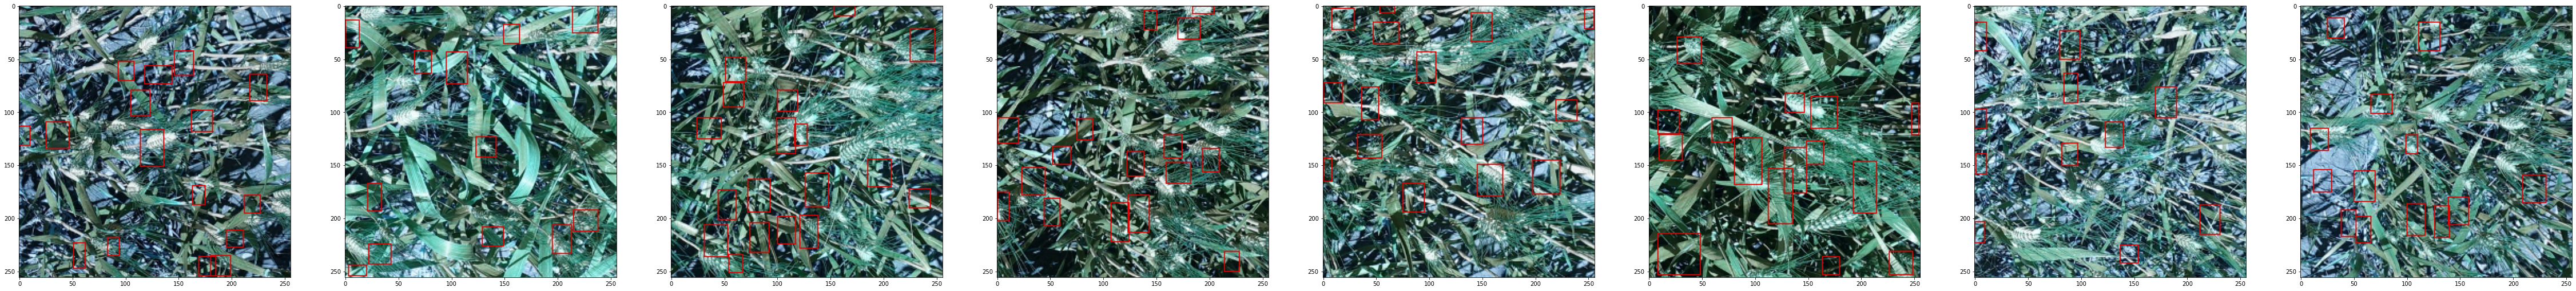

In [128]:
show_images(val_image_ids[0:8], val_preds)

In [110]:
lst = np.array(lst)

In [113]:
idx = np.array([1, 4])

In [114]:
lst[idx]

IndexError: index 4 is out of bounds for axis 0 with size 4